In [ ]:
### Importing functions

### 1. Patient-Run Definition and Data Loading

#### Print available runs for subject and settings-version

In [ ]:
# Explore available preprocessed runs
sub='008'
version='v2.0_Mar22'

importlib.reload(read_data)
read_data.show_runs(
    sub=sub,
    version=version,
    project_path=projectpath,
)


### SHOW RUNS ###
For subject 008, in preproc-version v2.0_Mar22 are available:

LFP_LEFT:
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa10']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa50']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa55']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa20']

LFP_RIGHT:
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa55']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa20']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['

#### Select and Load in runs to explore


Not defining task, acquisition or group results in selecting all available options

In [ ]:
# Select runs to explore/ ft-extract
importlib.reload(read_data)
fsel, groups, fdir = read_data.select_runs(
    sub=sub,
    version=version,
    project_path=projectpath,
    sess_incl=['EcogLfpMedOn02'],
    tasks_incl=['SelfpacedHandTapL', 'Rest'],
    # acqs_incl=[
    # #     'StimOffDopa00',
    #     'StimOffDopa15',
    #     # 'StimOffDopa35',
    # #     'StimOffDopa50',
    # ],
    # groups_incl=['LFP_RIGHT', 'LFP_LEFT', 'ECOG'],  # if not given, all groups are included
)
# print and check selected runs
# print(fsel)

In [ ]:
# Create dataclass per session
# session-dataclass wil contain dict with dataclasses containing
# data per run
importlib.reload(read_data)
SUB08 = read_data.SessionData(fsel, fdir)


In [ ]:
'''
PM: CREATE CLASS WITH WINDOWED FEATURES (EVERY 0.5 / 1 SEC, WITH 50% OVERLAP)

- WINDOWING BASED ON CURRENT SAMPLE-FREQ OF DATATYPE
- IN FT EXTRACTION PROCESS: ADDITIONAL FILTERING BEFORE WINDOWING!
- ADD CLASS WITH VIDEO-BASED EVENT RECOGNITION
    - dysk occurence:
        - coded for bodypart
        - coded for severity?
    - normal movement?
'''

#### Manual Video-Movement Annotation

In [ ]:
# annotate observed taps in video, integers are seconds
# from video start
# CAVE: orignal Video-starttime is hour in front
# values here are corrected one hour backwards (12->11)
# Still the video-time seems to be +/- 3 minutes behind
# the acc-neurophys-time
taptimes_video = {
    'SelfpacedHandTapL_StimOffDopa15': {
        'left': [
            1154, 1160, 1164, 1169, 1174, 1180, 1185,
            1191, 1195, 1201, 1207, 1226, 1238, 1243,
            1248, 1253
        ],
        'right':[
            1260, 1264, 1270, 1275, 1281, 1290, 1298,
            1303, 1308, 1313, 1320, 1324, 1332, 1339,
            1345
        ],
        'starttime': '2021-11-15 11:29' 
        # original 11:26 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa35': {
        'left': [
            878, 883, 888, 893, 898, 903, 908, 915,
            919, 926, 933, 946, 951, 957, 963, 970,
            976, 984
        ],
        'right':[
            1000, 1006, 1011, 1017, 1024, 1028, 1035,
            1041, 1054, 1060, 1081, 1089, 1097, 1103,
            1108
        ],
        'starttime': '2021-11-15 11:51:01'
        # original 11:48 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa60': {
        'left': [
            641, 647, 652, 657, 662, 666, 671, 676,
            682, 686, 692, 697, 703, 708, 713, 719,
        ],
        'right':[
            726, 730, 734, 740, 746, 751, 756, 761,
            768, 773, 779, 784, 792, 797, 801
        ],
        'starttime': '2021-11-15 12:22:59'  # video S1290007
        # original 12:20 but corrected for mismatching times
    }
}
# add timedelta in seconds to start-time of video
# CAVE videostarttime is on MINUTE-RESOLUTION
# thus will be SECONDS OF FROM ACC-TIMESTAMP
for run in taptimes_video:
    starttime = pd.Timestamp(taptimes_video[run]['starttime'])
    for side in ['left', 'right']:
        taptimes_video[run][f'{side}_stamps'] = []
        for sec in taptimes_video[run][side]:
            delta = pd.Timedelta(sec, 'sec')
            taptimes_video[run][f'{side}_stamps'].append(
                starttime + delta)

# Save annotation dict
# deriv_dir = os.path.join(
#     projectpath, 'data', 'analysis_derivatives', 'sub-008', 'taps'
# )
# dict_name = f'008_video_ann_tapruns'
# np.save(os.path.join(deriv_dir, dict_name),
#         taptimes_video)

# # Load annotation dict
# video_taps = np.load(os.path.join(deriv_dir, f'{dict_name}.npy'),
#                      allow_pickle=True).item()


In [ ]:
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
testannot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()
# testannot


#### Automated Acc-based Tap detection incl. plotting

In [ ]:
run = 'SelfpacedHandTapL_StimOffDopa35'
sides = ['left', 'right']
tap_fig_dir = os.path.join(projectpath, 'figures/tapping_detection')

In [ ]:
importlib.reload(tap_run)

restTest, tapTest, _ = tap_run.runTapDetection(
    task='paused', fs=SUB08.runs[run].acc_right_Fs,
    leftxyz=[accleft[run][0, :], accleft[run][1, :],
    accleft[run][2, :]], rightxyz=[accright[run][0, :],
    accright[run][1, :], accright[run][2, :]],
)



START left side
1.121970047728486e-07 17 17
logAND is TRUE from rest 366
start of TAP/MOV 1.3276377210030713e-07 366
after lowpeak(UP) coming back up 384
endUP 388
START DOWN MOVEMENT 464
Fastest DOWN MOVEMENT 475
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 1511
start of TAP/MOV 1.1851244079397509e-07 1511
after lowpeak(UP) coming back up 1526
endUP 1539
START DOWN MOVEMENT 1607
Fastest DOWN MOVEMENT 1614
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 2500
start of TAP/MOV 1.303586646046799e-07 2500
after lowpeak(UP) coming back up 2515
endUP 2519
START DOWN MOVEMENT 2594
Fastest DOWN MOVEMENT 2604
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 3499
start of TAP/MOV 1.3153520968013539e-07 3499
after lowpeak(UP) coming back up 3512
endUP 3518
START DOWN MOVEMENT 3601
Fastest DOWN MOVEMENT 3611
ended MOVE bcs next10 inactive
ended MOV

In [ ]:
### Main function to perform TapDetection functions
    ## make new main-function

importlib.reload(Tap2)

# accright, accleft = {}, {}
# restDict, tapDict, moveDict = {}, {}, {}

for run in SUB08.runs_incl[1:]:
    print(f'Start RUN: {run}')
    fs=SUB08.runs[run].acc_right_Fs
    accright[run] = SUB08.runs[run].acc_right_arr[1:, :]
    accleft[run] = SUB08.runs[run].acc_left_arr[1:, :]

    restDict[run], tapDict[run], moveDict[run] = runTapDetection(
        task='paused', fs=SUB08.runs[run].acc_right_Fs,
        leftxyz=[accleft[run][0, :], accleft[run][1, :],
        accleft[run][2, :]], rightxyz=[accright[run][0, :],
        accright[run][1, :], accright[run][2, :]],
    )


Start RUN: SelfpacedHandTapL_StimOffDopa60


START left side
1.012731518833157e-07 17 14
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 946
start of TAP/MOV 1.1483229646828269e-07 946
after lowpeak(UP) coming back up 1048
endUP 1055
ended MOVE bcs next10 inactive
logAND is TRUE from rest 2131
start of TAP/MOV 1.2207354651560685e-07 2131
after lowpeak(UP) coming back up 2153
endUP 2157
START DOWN MOVEMENT 2229
Fastest DOWN MOVEMENT 2239
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 3107
start of TAP/MOV 1.2677018217050875e-07 3107
after lowpeak(UP) coming back up 3122
endUP 3126
START DOWN MOVEMENT 3195
Fastest DOWN MOVEMENT 3202
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 4029
start of TAP/MOV 1.2250273844703196e-07 4029
after lowpeak(UP) coming back up 4045
endUP 4050
START DOWN MOVEMENT 4106
Fastest DOWN MOVEMENT 4117
ended MOVE bc

In [ ]:
### (function to be) get runstartTimes (include in RUN CLASS (real and dopa times))
deriv_dir = os.path.join(projectpath, 'data/analysis_derivatives')
runTimes = pd.read_excel(
    os.path.join(deriv_dir, f'sub-{sub}', f'sub{sub}_runsInfo.xlsx'))

runStartTimes = {}
for run in SUB08.runs_incl:
    for row in np.arange(runTimes.shape[0]):
        if run[-6:] in runTimes.iloc[row]['filename']:
            t = runTimes.iloc[row]['acq_time']
            runStartTimes[run] = pd.Timestamp(t)

In [ ]:
### Import and process video-annotated tap-times ###

## (function to be) Convert video-annotated tap-stamps
## into seconds after tmsi-recording

# import annotated taptimes (function to be?)
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
tapAnnot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()

ann_times = {}
tapsAnnot_in_runSecs = {}

for run in tapDict.keys():
    if 'Tap' not in run: continue

    # real-time timestamps of video-annotated taps
    dt_string = '%Y-%m-%d %H:%M:%S'
    t0 = tapAnnot[run]['starttime']
    try:
        t0 = dt.datetime.strptime(t0, dt_string)
    except ValueError:
        t0 = dt.datetime.strptime(t0, '%Y-%m-%d %H:%M')

    ann_times[run] = {}
    tapsAnnot_in_runSecs[run] = {}

    for side in sides:
        ann_times[run][side] = [t0 + dt.timedelta(
            seconds=t) for t in tapAnnot[run][side]]
    # minus video start-time -> time after video-start
        tapsAnnot_in_runSecs[run][side] = [
            (t - runStartTimes[run]).total_seconds(
            ) for t in ann_times[run][side]
        ]


In [ ]:
### TO DO:
# - WHY IS check_Polarity turning the signal falsely?
# - Why is tapdetection from TapDopa15 Right empty? 
    # plot incl peaks and thresholds etc

# - include plotting of OTHER MVOEMENTS
# - split py function for tapping in several py docs!!

Plot Figure for run SelfpacedHandTapL_StimOffDopa15


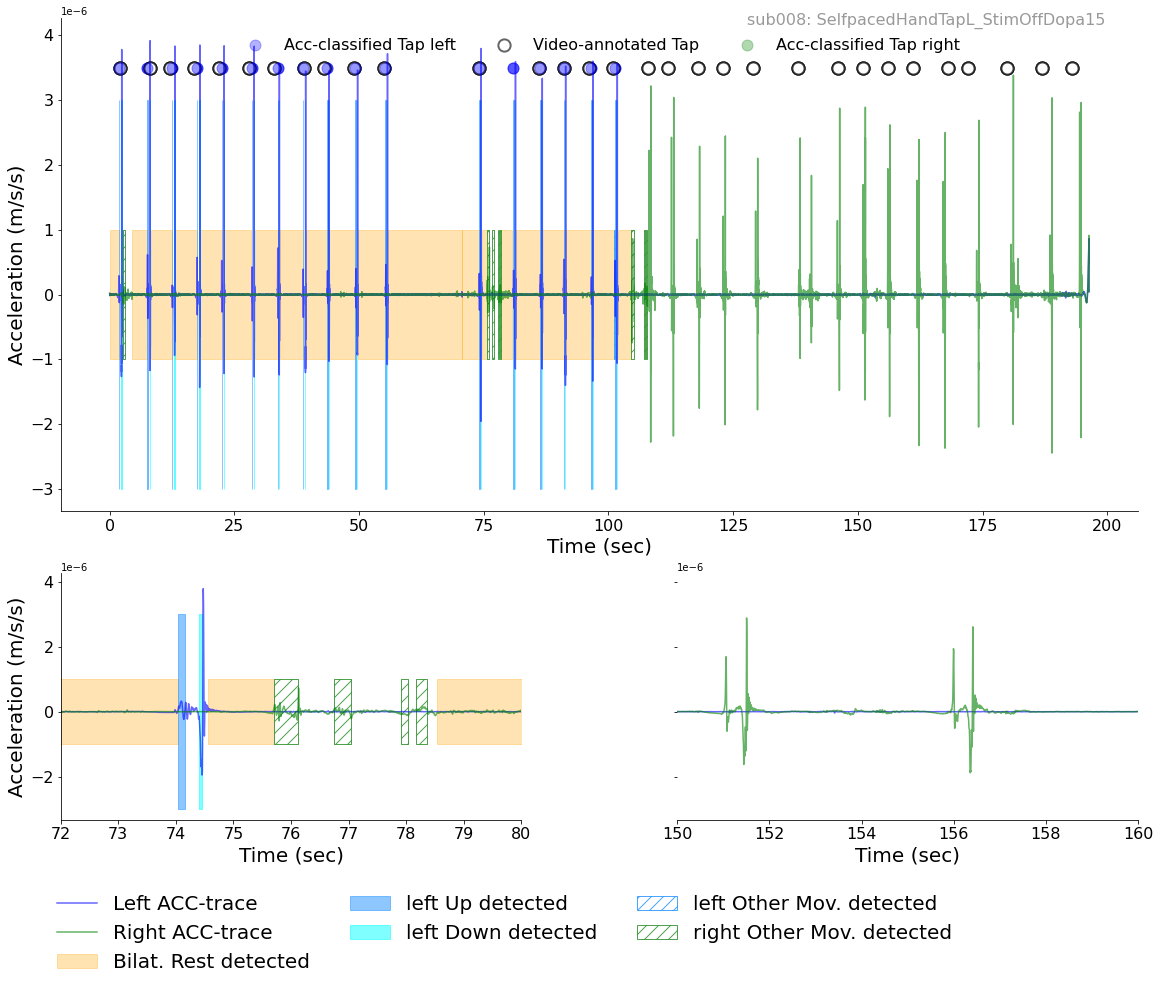

In [ ]:
### Create plotting functions for tapping

from matplotlib.gridspec import GridSpec

run = list(tapsAnnot_in_runSecs.keys())[2]

print(f'Plot Figure for run {run}')
# specify x-coordinates of zoomed-in subplots
ax1_x1, ax1_x2 = 72, 80
ax2_x1, ax2_x2 = 150, 160
plot_fname=f'TapDetect_08_{run}'
if ax1_x1: plot_fname += f'_zooms_{ax1_x1}_{ax2_x1}'
plot_fdir=tap_fig_dir

plot_params = {
        'left': {
            'color': 'b',
            'alpha': .6
        },
        'right': {
            'color': 'g',
            'alpha': .6
        },
        'rest': {
            'color': 'orange',
            'alpha': .3
        },
        'left_up': {
            'color': 'dodgerblue',
            'alpha': .5
        },
        'left_down': {
            'color': 'cyan',
            'alpha': .5
        },
        'left_other': {
            'facecolor': 'white',
            'edgecolor': 'dodgerblue',
            'alpha': .8,
            'hatch': '//'
        },
        'right_up': {
            'color': 'forestgreen',
            'alpha': .5
        },
        'right_down': {
            'color': 'lime',
            'alpha': .5
        },
        'right_other': {
            'facecolor': 'white',
            'edgecolor': 'forestgreen',
            'alpha': .8,
            'hatch': '//'
        }
    }

fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = GridSpec(3, 9, figure=fig)

ax0 = fig.add_subplot(gs[:2, :])
ax1 = fig.add_subplot(gs[2, :4])
ax2 = fig.add_subplot(gs[2, 5:], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

for ax in [ax0, ax1, ax2]:
    # Plotting traces
    ax.plot(
        np.arange(0, accleft[run][1, :].shape[0]) / fs,
        accleft[run][1, :], **plot_params['left'],
        label='Left ACC-trace',
    )
    ax.plot(
        np.arange(0, accright[run][1, :].shape[0]) / fs,
        accright[run][1, :], **plot_params['right'],
        label='Right ACC-trace',
    )
    # Plot bilateral Rest-epochs
    for d in restDict[run]:
        ax.fill_betweenx(label='Bilat. Rest detected',
            y=[-1e-6, 1e-6], x1=restDict[run][d][0],
            x2=restDict[run][d][1],
            **plot_params['rest'],)

    # Plot Tap and other-movem. epochs
    for side in ['left', 'right']:
        ## plot Taps
        for t, tList in enumerate(tapDict[run][side]):
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[0], x2=tList[2],
                label=f'{side} Up detected',
                **plot_params[f'{side}_up'],
            )
            # ax.scatter(tList[1], )  # plot fastest point
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[3], x2=tList[4],
                label=f'{side} Down detected',
                **plot_params[f'{side}_down'],
            )
        
        ## Plot Other Movement's
        for t, tList in enumerate(moveDict[run][side]):
            ax.fill_betweenx(
                y=[-1e-6, 1e-6],
                x1=tList[0], x2=tList[1],
                label=f'{side} Other Mov. detected',
                **plot_params[f'{side}_other'],
            )
        
        ## Plot Accuracy circles based on video-annotations
        vid_circle_pos = tapsAnnot_in_runSecs[run][side]
        acc_circle_pos = [t[0] for t in tapDict[run][side]]
        ax0.scatter(
            vid_circle_pos, [3.5e-6] * len(vid_circle_pos),
            s=150, edgecolor='k', facecolor='w', lw=2,
            label='Video-annotated Tap', **plot_params['left'],
        )
        ax0.scatter(
            acc_circle_pos, [3.5e-6] * len(acc_circle_pos),
            s=120, color=plot_params[side]['color'], alpha=.3,
            label=f'Acc-classified Tap {side}'
        )
        tapAcc_handles, tapAcc_labels = ax0.get_legend_handles_labels()
        tapAcc_handles = tapAcc_handles[-3:]
        tapAcc_labels = tapAcc_labels[-3:]
        ax0.legend(tapAcc_handles, tapAcc_labels,
            fontsize=16, ncol=3, frameon=False,
            loc='upper center', bbox_to_anchor=(.5, .99))

        # plot findpeak dots to optimize algorithm
        # posPeaks = signal.find_peaks(
        #     accleft[run][1, :],
        #     height=np.max(accleft[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='k')
        # posPeaks = signal.find_peaks(
        #     accright[run][1, :],
        #     height=np.max(accright[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='gray')
        
        
    # make plots pretty
    ax.set_xlabel('Time (sec)', size=20)
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # helping lines for alforithm finetuning
    # ax.axhline(np.median(spos), label='median')
    # ax.axhline(np.percentile(spos, 75), label='75-%', ls='dotted')
    # ax.axhline(-np.percentile(spos, 75), label='-75-%', color='red', ls='dotted')

# make plot pretty
for ax in [ax0, ax1]: ax.set_ylabel('Acceleration (m/s/s)', size=20)
ax2.spines['left'].set_visible(False)

# define zoomed subplots
ax1.set_xlim(ax1_x1, ax1_x2)
ax2.set_xlim(ax2_x1, ax2_x2)

# get rid off duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    fontsize=20, frameon=False, ncol=3,
    loc='upper left', bbox_to_anchor=(.03, -.01)
)
plt.suptitle(f'sub008: {run}', x=.8, y=.99,
    color='gray', alpha=.8, fontsize=16,)
# plt.tight_layout(pad=.1)

plt.savefig(os.path.join(plot_fdir, plot_fname),
    dpi=150, facecolor='white', bbox_inches='tight')

plt.show()

In [ ]:
### PLOTTING ###
## using xyz input and output-indices of pausedTap function
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(xEpoch, label='x', alpha=.5, c='blue')
ax.plot(yEpoch, label='y', alpha=.8, c='green')
ax.plot(zEpoch, label='z', alpha=.5, c='orange')
# plot vertical lines at tap-moments
for t, tap in enumerate(tapi):
    if t == 0:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5, label='start UP')
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5, label='end UP')
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5, label='start DOWN')
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5, label='end DOWN')
    else:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5,)
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5,)
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5,)
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5,)

peaklabel = ['lowPos', 'highPos', 'lowNeg', 'highNeg']
peakcol = ['lightgreen', 'green', 'orange', 'r']
for p, peaks in enumerate([smallPos, largePos, smallNeg, largeNeg]):
    ax.scatter(
        peaks[0],
        yEpoch[peaks[0]],
        label=peaklabel[p],
        color=peakcol[p],
        s=50,
    )

for mov in movei:  # check saved otherMovements
    ax.axvline(mov[0], color='gray', lw=1, ls='dotted')
    ax.axvline(mov[-1], color='gray', lw=1)

# ax.axhline(-.5e-7)
ax.axhline(posThr)
ax.axhline(0, c='gray', lw=.5,)
# determine what to show
ax.set_ylim(-2.5e-6, 2.5e-6)
# ax.set_xlim(istart, istop)
ax.set_xlim(0, 30000)
# ax.set_xticks(np.arange(18600, 20001, 200))
# ax.set_xticklabels(np.arange(18600, 20001, 200) // 200)
xticks = np.arange(0, len(yEpoch), 6000)
xlabs = np.arange(0, len(yEpoch) / 12000, .5)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_ylabel('Raw Acceleration (m/s/s)', size=14)
ax.set_xlabel('Time (minutes)', size=14)

ax.set_title(run)

# ax.legend(frameon=False, fontsize=14, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot Rest-moments
for idx in resti:
    ax.fill_betweenx(
        y=np.linspace(-3e-6, 3e-6, 5), x1=idx[0], x2=idx[1],
        color='blue', alpha=.1,)

if to_save:
    plt.savefig(
        os.path.join(temp_save, 'ACC', f'mountFingerTap_sub08_{run[-6:]}_2'),
        dpi=300, facecolor='w',
    )
plt.show()

print(f'{run} finisihed')

169.42

In [ ]:
tempdir = ('/Users/jeroenhabets/Research/CHARITE/projects/'
    'dyskinesia_neurophys/data/analysis_derivatives/sub-008/May03')


In [ ]:
def SelAndSave_Restblocks(
    neu_data, fs, neu_names, restTimes, runname, winlen=1024,
    neu_ch_incl=[],
):
    for neu_chi in np.arange(1, neu_data.shape[0]):
        neudat = neu_data[neu_chi, :]
        neuTimes = neu_data[0, :]
        neu_ch = neu_names[neu_chi]  # channel name
        print(neu_ch)
        if neu_ch_incl:
            if neu_ch not in neu_ch_incl: continue

        tempdat = np.zeros((1, winlen))
        rowTimes = []  # list to store times corresponding to data rows

        for n, timeIdx in enumerate(restTimes[1:-1]):  # skip first and last
            neuInd1 = np.where(neuTimes == timeIdx[0])[0][0]
            neuInd2 = np.where(neuTimes == timeIdx[1])[0][0]
            dat_sel = neudat[neuInd1:neuInd2]
            n_wins = len(dat_sel) // winlen
            dat_sel = np.reshape(
                dat_sel[:n_wins * winlen],
                (n_wins, winlen),
                order='C',  # fills row after row
            )
            tempdat = np.vstack([tempdat, dat_sel])
            for i in np.arange(n_wins):
                rowTimes.append(timeIdx[0] + (i * winlen / fs))

        rowTimes = np.round(rowTimes, 3)  # round .019999 values
        tempdat = tempdat[1:, :]  # exclude first row of zeros

        # saving data array
        fname = f'{runname}_{neu_ch}_win{winlen}'
        # np.save(os.path.join(
        #     tempdir, 'restblocks', f'restBlocks_sub08_{fname}'), tempdat)
        # save list of rowtimes
        np.save(os.path.join(
            tempdir, 'restblocks', f'restTimes_sub08_{fname}'), rowTimes)


    # return tempdat, rowTimes

In [ ]:
neusource = 'lfp_left'
_, _ = SelAndSave_Restblocks(
    neu_data = getattr(SUB08.runs[run], f'{neusource}_arr'),
    fs = getattr(SUB08.runs[run], f'{neusource}_Fs'),
    neu_names = getattr(SUB08.runs[run], f'{neusource}_names'),
    restTimes=restTimes,
    runname=run[-6:],
)

'''
IMPORTANT: CHECK VIDEO - TMSi TIME DIFF
# second left-mov (tap) in video at 19:19
# -> video Timestamp('2021-11-15 11:45:20')
# -> acc from 2021-11-15 11:48:19.395000 
#           to 2021-11-15 11:48:20.300000

# first right-mov (dysk) in video at 19:14
#  -> video Timestamp('2021-11-15 11:47:00')
#  -> acc from 2021-11-15 11:48:14.505000
#           to 2021-11-15 11:48:16.040000

# Rest recording starts in video at 12:52
# -> video first movements right between 13:00 +/- 00:02:
#   stamp is 11:26:00 + 00:13:00 -> 11:39:00 +/- 00:02
# IN ACC: 11:42:00 +/- 00:02
# ERGO: For Rest10, Tapping15: ACC-time is 03:00 ahead of Video